In [40]:
%pylab inline
import os
import gc
import glob
import numpy as np
import astropy.io.fits as pyfits
import astropy.table as astTab
import maputil as mapUtil

Populating the interactive namespace from numpy and matplotlib


# Prepare small catalogs

In [8]:
colnames=['tract','Id','ra','dec','g1','g2','weight','bias_m','dnn_zbest','dnn_zbest_std','demp_zbest','demp_zbest_std','mizuki_zbest','mizuki_zbest_std']
for fieldname in mapUtil.field_names:
    print(fieldname)
    data=pyfits.getdata('datDir/catalog_obs_reGaus_no_m/%s_no_m.fits' %fieldname)
    zata=pyfits.getdata('datDir/catalog_others/%s_pz_2.fits' %fieldname)
    ra=data['i_ra']
    dec=data['i_dec']
    e1      =   data['i_hsmshaperegauss_e1']
    e2      =   data['i_hsmshaperegauss_e2']
    m_b     =   np.zeros(len(data))
    Id      =   data['object_id']
    tract   =   data['tract']
    c1_b    =   data['i_hsmshaperegauss_derived_shear_bias_c1']
    c2_b    =   data['i_hsmshaperegauss_derived_shear_bias_c2']
    weight  =   data['i_hsmshaperegauss_derived_weight']
    dnnzBest=   zata['dnnz_photoz_best']
    dnnzStd =   zata['dnnz_photoz_std_best']
    dempzBest=   zata['demp_photoz_best']
    dempzStd =   zata['demp_photoz_std_best']
    mizukizBest=   zata['mizuki_photoz_best']
    mizukizStd =   zata['mizuki_photoz_std_best']
    print(np.sum(np.isnan(zata['mizuki_photoz_best'])))
    w_A     =   np.sum(weight)
    m_bA    =   np.sum(m_b*weight)/w_A
    Res_A   =   1.-np.sum(data['i_hsmshaperegauss_derived_rms_e']**2.*weight)/w_A
    print('response: %s' %Res_A)
    print('multiplicative bias: %s' %m_bA)
    g1      =   1./(1.+m_bA)*(e1/2./Res_A-c1_b)
    g2      =   1./(1.+m_bA)*(e2/2./Res_A-c2_b)
    dataOut=astTab.Table(names=colnames,data=[tract,Id,ra,dec,g1,g2,weight,m_b,dnnzBest,dnnzStd,dempzBest,dempzStd,mizukizBest,mizukizStd])
    dataOut.meta.update({'ra_min':np.min(ra)})
    dataOut.meta.update({'dec_min':np.min(dec)})
    dataOut.meta.update({'ra_max':np.max(ra)})
    dataOut.meta.update({'dec_max':np.max(dec)})
    dataOut.write('wrkDir/reGaus_catalog/%s.fits' %fieldname,overwrite=True)
    if False:
        break
    else:
        del g1,g2,data,m_b,c1_b,c2_b,dnnzBest,dnnzStd,dempzBest,dempzStd,mizukizBest,mizukizStd,dataOut
        gc.collect()

XMM
0
response: 0.8468188729925158
multiplicative bias: 0.0
GAMA09H
0
response: 0.8442931499596258
multiplicative bias: 0.0
WIDE12H
0
response: 0.8447782679393657
multiplicative bias: 0.0
GAMA15H
0
response: 0.8432363259597689
multiplicative bias: 0.0
VVDS
0
response: 0.8418525728419027
multiplicative bias: 0.0
HECTOMAP
0
response: 0.8422453076863876
multiplicative bias: 0.0


# Divide into groups

In [33]:
pad=1.
for fieldname in mapUtil.field_names:
    outDir='wrkDir/reGaus_catalog/%s_groups/' %fieldname
    if not os.path.isdir(outDir):
        os.mkdir(outDir)
    
    data=pyfits.getdata('wrkDir/reGaus_catalog/%s.fits' %fieldname)
    if fieldname=='VVDS':
        addR=(data['ra']<300.).astype(int)*360
        data['ra']+=addR
    ymin=np.min(data['dec'])
    ymax=np.max(data['dec'])
    ny=mapUtil.field_ny[fieldname]
    ybound=np.linspace(ymin,ymax,ny+1)
    ylow=ybound[:-1];yhigh=ybound[1:]
    ylow=ylow-pad;yhigh=yhigh+pad
    for iy in range(ny):
        ymean= (ybound[iy]+ybound[iy+1])/2.
        mask0= (data['dec']>ymean+iy*1.-1.)&(data['dec']<=ymean+iy*1.)
        dataT= data[mask0]
        xmin=  np.min(dataT['ra'])
        xmax=  np.max(dataT['ra'])
        del dataT
        gc.collect()
        nx  =  int((xmax-xmin)/6.)+1
        xbound=np.linspace(xmin,xmax,nx+1)
        xlow=xbound[:-1];xhigh=xbound[1:]
        xlow=xlow-pad;xhigh=xhigh+pad
        for ix in range(nx):
            mask=(data['ra']>xlow[ix])&(data['ra']<xhigh[ix]) \
                &(data['dec']>ylow[iy])&(data['dec']<yhigh[iy])
            dataU=data[mask]
            if np.sum(mask)>100. and np.max(dataU['dec'])>ylow[iy]+pad*2. and np.min(dataU['dec'])<yhigh[iy]-pad*2.:
                pyfits.writeto(os.path.join(outDir,'src-group-%d%d.fits' %(iy,ix)),dataU)
        del mask0,dataU
        gc.collect()
    del data
    gc.collect()

# Pixelization

In [107]:
for fieldname in mapUtil.field_names:
    outDir='wrkDir/reGaus_catalog/%s_groups/' %fieldname
    assert os.path.isdir(outDir)
    fnames=glob.glob(os.path.join(outDir,'src-group-*.fits'))
    print(fnames)
    for fname in fnames:
        assert os.path.isfile(fname)
        data=pyfits.getdata(fname)
        break
    break

['wrkDir/reGaus_catalog/XMM_groups/src-group-00.fits', 'wrkDir/reGaus_catalog/XMM_groups/src-group-10.fits', 'wrkDir/reGaus_catalog/XMM_groups/src-group-11.fits', 'wrkDir/reGaus_catalog/XMM_groups/src-group-01.fits']


In [108]:
data.names

['tract',
 'Id',
 'ra',
 'dec',
 'g1',
 'g2',
 'weight',
 'bias_m',
 'dnn_zbest',
 'dnn_zbest_std',
 'demp_zbest',
 'demp_zbest_std',
 'mizuki_zbest',
 'mizuki_zbest_std']

In [111]:
mask=(~np.isnan(data['dnn_zbest']))\
    &(data['dnn_zbest_std']<1.0)\
    &(data['dnn_zbest']<3.0)\
    &(data['dnn_zbest']>0.05)
print(np.sum(mask)/len(mask))
data=data[mask]
bins=np.percentile(data['dnn_zbest'],np.linspace(0,100,11))

0.9291141179359076


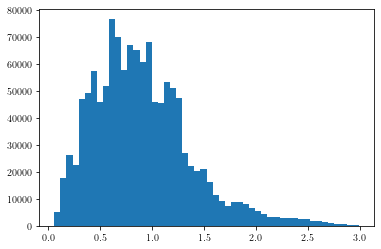

In [103]:
down,_,_=plt.hist(data['dnn_zbest'],bins=50)

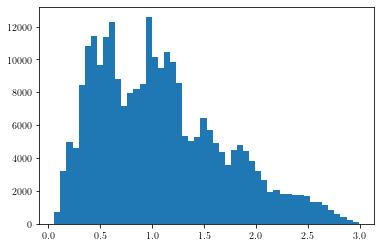

In [104]:
up,x,_=plt.hist(data['dnn_zbest'],weights=data['dnn_zbest_std'],bins=50)

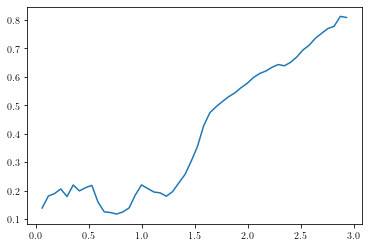

In [105]:
plt.plot(x[:-1],up/down)

In [106]:
bins

array([0.06      , 0.36000001, 0.5       , 0.62      , 0.73000002,
       0.85000002, 0.94999999, 1.10000002, 1.24000001, 1.5       ,
       2.99000001])